In [2]:
vid_path = "/home/hoffman/Documents/UT/Stuffs/Applied ML/project/data/test.mp4"

In [3]:
from decord import VideoReader
from decord import cpu, gpu

In [4]:
vr = VideoReader(vid_path, ctx=cpu(0))

In [5]:
len(vr)

46199

In [21]:
frames = vr.get_batch([range(2000,4000)]).asnumpy()

In [22]:
import numpy as np
import cv2
from sklearn.cluster import KMeans

def detect_pitch(frame):
    """
    Detects if a given frame contains a cricket pitch based on clustering and segmentation.

    Args:
        frame (numpy.ndarray): Input image of size H x W x 3.

    Returns:
        bool: True if the frame contains the pitch, False otherwise.
        numpy.ndarray: Mask of the segmented pitch (binary image).
    """
    # Resize frame for consistent processing
    resized_frame = cv2.resize(frame, (300, 300))
    
    # Flatten the image into a 2D array of pixels (each row is a color [R, G, B])
    pixels = resized_frame.reshape(-1, 3)
    
    # Apply K-Means clustering with 3 clusters
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(pixels)
    clusters = kmeans.cluster_centers_
    
    # Reshape the labels back to the original image dimensions
    label_image = labels.reshape(resized_frame.shape[:2])
    
    # Identify the cluster with the least color variance
    cluster_variances = []
    for i in range(3):
        cluster_pixels = pixels[labels == i]
        variance = np.var(cluster_pixels, axis=0).mean()
        cluster_variances.append(variance)
    
    pitch_cluster = np.argmin(cluster_variances)
    
    # Create a binary mask for the pitch cluster
    pitch_mask = (label_image == pitch_cluster).astype(np.uint8)
    
    # Perform morphological processing to refine the segmentation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_CLOSE, kernel)
    pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_OPEN, kernel)
    
    # Validate the segment: check size and spatial location
    num_pixels = cv2.countNonZero(pitch_mask)
    h, w = resized_frame.shape[:2]
    
    # Condition: Segment should occupy a reasonable area of the frame
    if 0.1 * h * w < num_pixels < 0.5 * h * w:
        return True, pitch_mask  # Pitch is detected
    else:
        return False, pitch_mask  # No pitch detected


In [23]:
import cv2
import numpy as np

def contains_pitch(frame: np.ndarray) -> bool:
    """
    Determines if a given frame contains a cricket pitch based on color clustering.

    Args:
        frame (np.ndarray): Input color image of shape (H, W, 3).

    Returns:
        bool: True if the frame contains a pitch, False otherwise.
    """
    # Step 1: Resize the image for faster processing
    resized_frame = cv2.resize(frame, (300, 300))  # Resize to a fixed size for consistency
    h, w, _ = resized_frame.shape
    pixels = resized_frame.reshape(-1, 3).astype(np.float32)

    # Step 2: Apply k-means clustering (3 clusters)
    k = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    labels = labels.reshape((h, w))

    # Step 3: Calculate color variance for each cluster
    variances = []
    for i in range(k):
        cluster_pixels = pixels[labels.flatten() == i]
        variances.append(np.var(cluster_pixels))

    # Identify the cluster with the smallest variance
    pitch_cluster = np.argmin(variances)

    # Step 4: Back-project the pitch cluster to create a binary mask
    pitch_mask = (labels == pitch_cluster).astype(np.uint8)

    # Step 5: Validate the pitch based on spatial location and morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_CLOSE, kernel)
    pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_OPEN, kernel)

    # Find contours of the potential pitch
    contours, _ = cv2.findContours(pitch_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Validate based on area and aspect ratio
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        area = cv2.contourArea(contour)
        
        # Check if the region matches expected pitch properties
        if 0.5 < aspect_ratio < 2.0 and area > 5000:  # Example thresholds
            return True  # Pitch detected

    return False  # No valid pitch found


In [24]:
import cv2
import numpy as np

def contains_pitch(frame: np.ndarray) -> bool:
    """
    Determines if a given frame contains a cricket pitch based on color clustering.

    Args:
        frame (np.ndarray): Input color image of shape (H, W, 3).

    Returns:
        bool: True if the frame contains a pitch, False otherwise.
    """
    # Step 1: Resize the image for faster processing
    resized_frame = cv2.resize(frame, (300, 300))  # Resize to a fixed size for consistency
    h, w, _ = resized_frame.shape
    pixels = resized_frame.reshape(-1, 3).astype(np.float32)

    # Step 2: Apply k-means clustering (3 clusters)
    k = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    labels = labels.reshape((h, w))

    # Step 3: Calculate color variance for each cluster
    variances = []
    for i in range(k):
        cluster_pixels = pixels[labels.flatten() == i]
        variances.append(np.var(cluster_pixels))

    # Identify the cluster with the smallest variance
    pitch_cluster = np.argmin(variances)

    # Step 4: Back-project the pitch cluster to create a binary mask
    pitch_mask = (labels == pitch_cluster).astype(np.uint8)

    # Step 5: Validate the pitch based on spatial location and morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_CLOSE, kernel)
    pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_OPEN, kernel)

    # Find contours of the potential pitch
    contours, _ = cv2.findContours(pitch_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Validate based on area and aspect ratio
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        area = cv2.contourArea(contour)
        
        # Check if the region matches expected pitch properties
        if 0.5 < aspect_ratio < 2.0 and area > 5000:  # Example thresholds
            return True  # Pitch detected

    return False  # No valid pitch found



contains_pitch(frames[44])

True

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_histogram_with_blur(frame: np.ndarray, blur_kernel_size: tuple = (3, 3)) -> None:
    """
    Applies Gaussian blur to the grayscale image, then computes and visualizes the histogram of the blurred image.

    Args:
        frame (np.ndarray): Input color image of shape (H, W, 3).
        blur_kernel_size (tuple): Size of the Gaussian blur kernel (default is (5, 5)).
    """
    # Step 1: Convert the RGB frame to grayscale
    grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Apply Gaussian blur to the grayscale image
    blurred_frame = cv2.GaussianBlur(grayscale_frame, blur_kernel_size, 0)
    
    plt.imshow(blurred_frame, cmap='gray')
  

    
    # Step 3: Compute the histogram of the blurred grayscale image
    hist = cv2.calcHist([blurred_frame], [0], None, [256], [0, 256])
    
    # Step 4: Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.plot(hist, color='black')
    plt.title('Grayscale Histogram with Gaussian Blur')
    plt.xlabel('Grayscale Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    # Step 5: Display the plot
    plt.show()

# Example usage:
# Assuming `frame` is the input image
# frame = cv2.imread('path_to_image.jpg')
# compute_histogram_with_blur(frame)


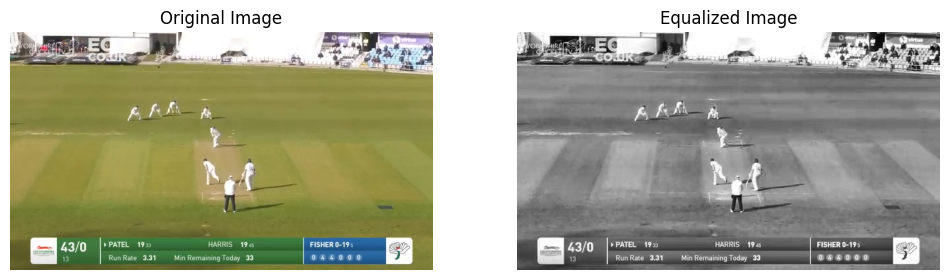

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def increase_contrast_and_equalize(image: np.ndarray, clahe: bool = False) -> np.ndarray:
    """
    Increases the contrast of the image by applying histogram equalization.
    
    Args:
        image (np.ndarray): Input image (H x W x 3) in RGB format.
        clahe (bool): Whether to apply CLAHE (default is False). If False, normal histogram equalization is used.
    
    Returns:
        np.ndarray: The contrast-enhanced and equalized image.
    """
    # Convert the image to grayscale for easier processing
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Option 1: Normal Histogram Equalization
    if not clahe:
        equalized_image = cv2.equalizeHist(grayscale_image)
    # Option 2: CLAHE for more localized contrast enhancement
    else:
        clahe_obj = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized_image = clahe_obj.apply(grayscale_image)
    
    # Convert the equalized grayscale image back to RGB
    equalized_image_rgb = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2RGB)
    
    return equalized_image_rgb

image_rgb = frames[256]

# Apply contrast enhancement and equalization
equalized_image = increase_contrast_and_equalize(image_rgb, clahe=True)

# Display the original and equalized image
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Equalized image
plt.subplot(1, 2, 2)
plt.imshow(equalized_image)
plt.title("Equalized Image")
plt.axis("off")

plt.show()


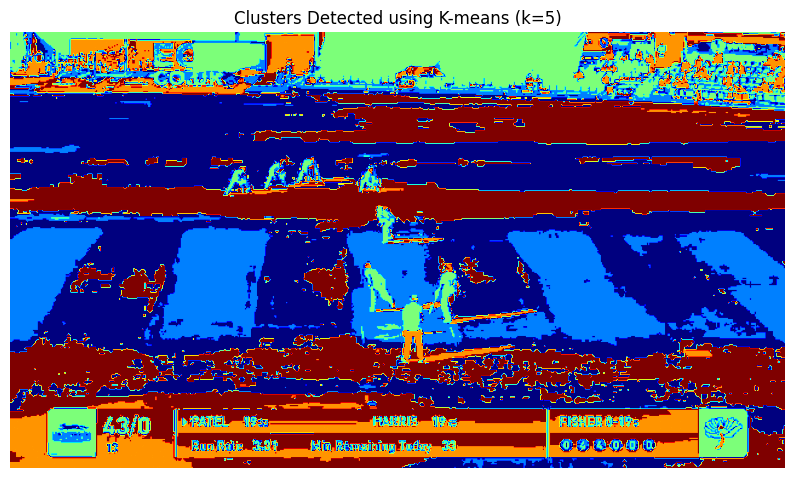

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def detect_pitch_using_kmeans(image: np.ndarray, k: int = 5) -> None:
    """
    Detects clusters in the image using K-means and visualizes the clusters.
    
    Args:
        image (np.ndarray): Input image (H x W x 3) in RGB format.
        k (int): The number of clusters to detect (default is 3).
    """
    # Step 1: Convert RGB to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  
    
    # Step 2: Reshape the image to (num_pixels, 3) for clustering
    reshaped_image = hsv_image.reshape((-1, 3))
    
    # Step 3: Apply K-means for clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(reshaped_image)
    
    # Step 4: Get the labels of the clusters
    labels = kmeans.labels_
    
    # Step 5: Reshape the labels to the original image shape
    clustered_image = labels.reshape(image.shape[0], image.shape[1])
    
    # Step 6: Visualize the clusters on the image
    plt.figure(figsize=(10, 6))
    plt.imshow(clustered_image, cmap='jet')
    plt.title(f'Clusters Detected using K-means (k={k})')
    plt.axis('off')  # Hide axis for better visualization
    plt.show()


detect_pitch_using_kmeans(equalized_image)


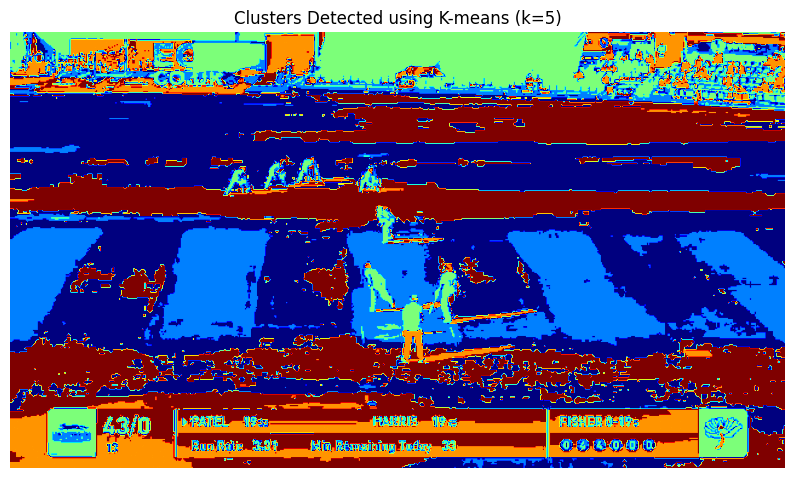

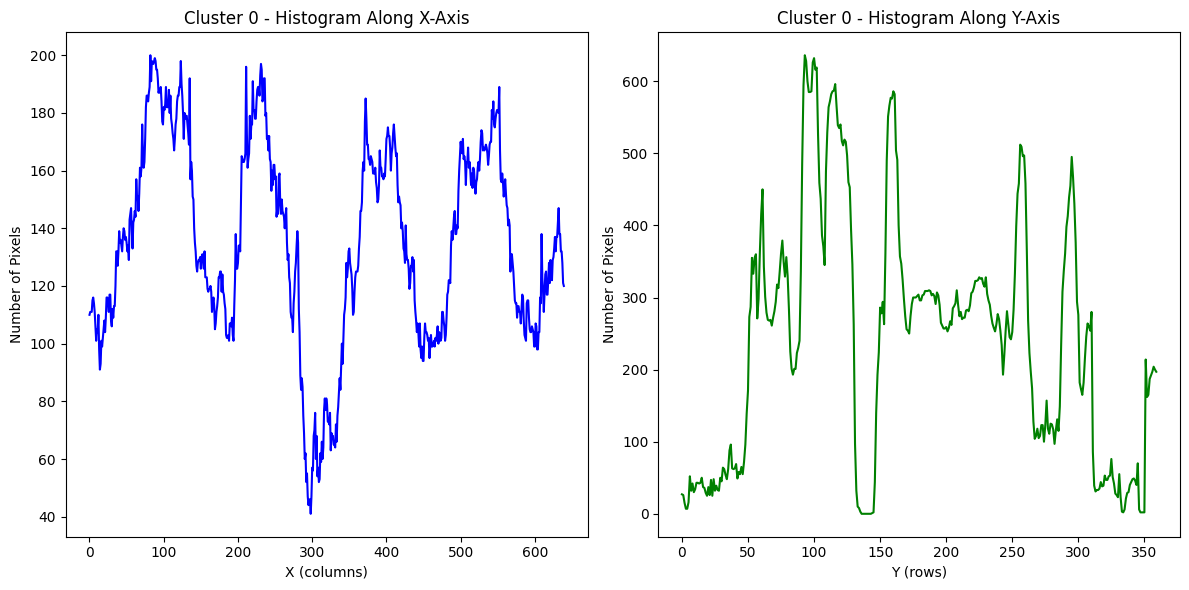

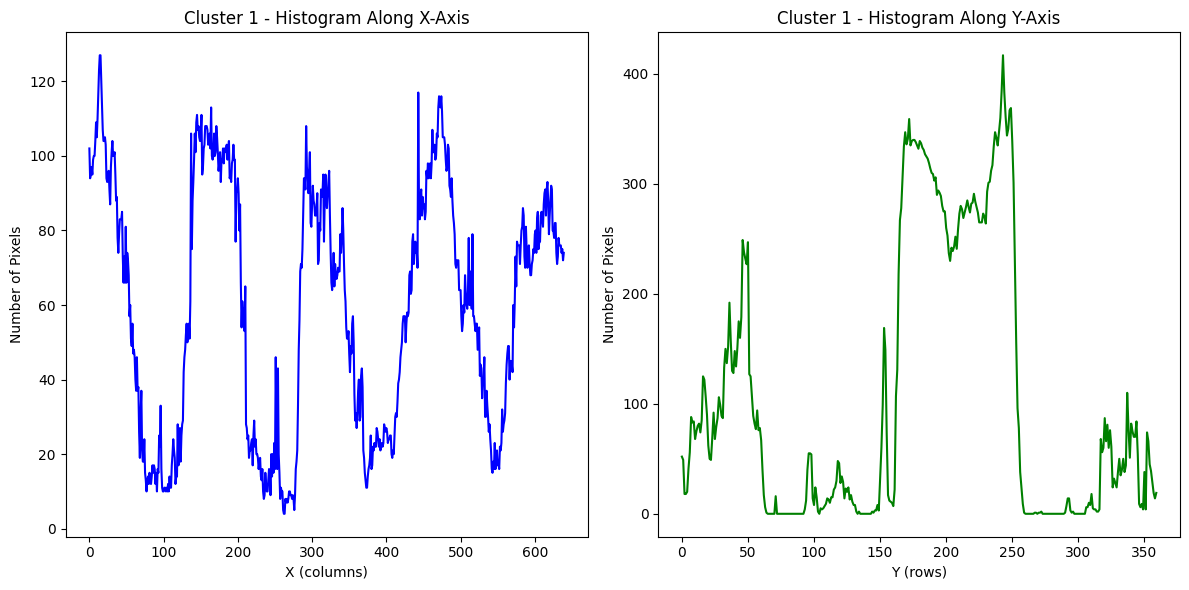

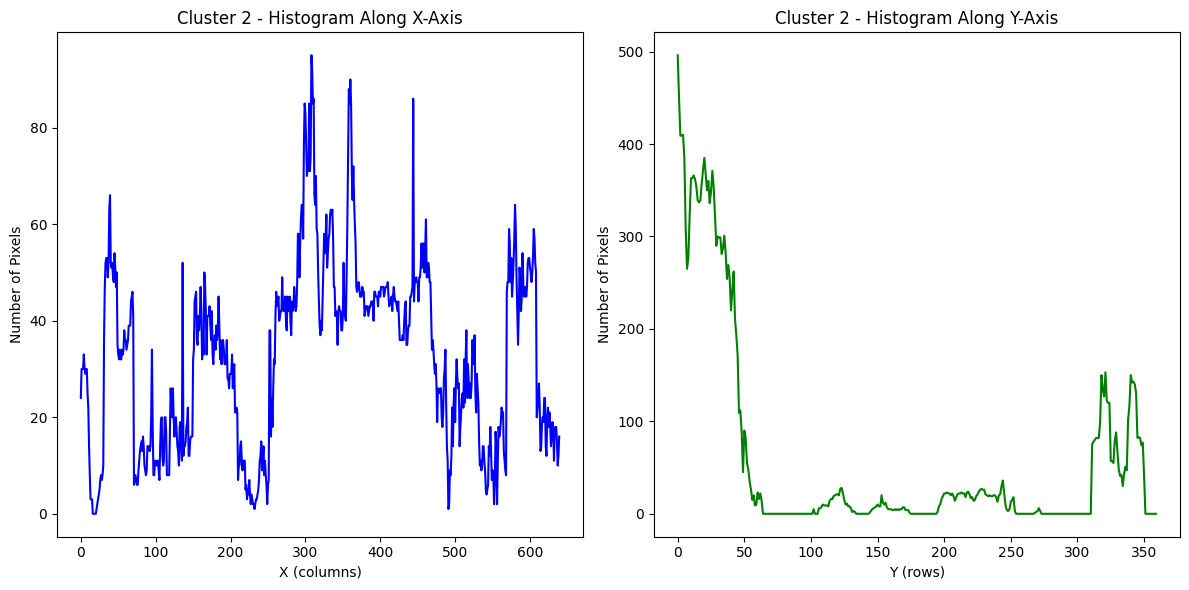

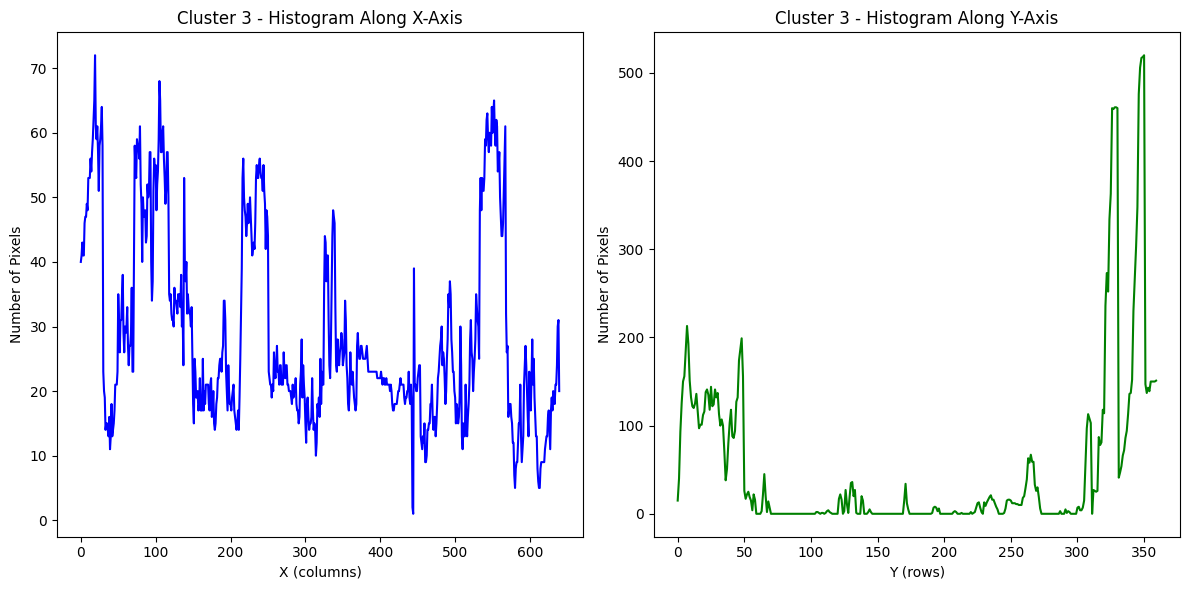

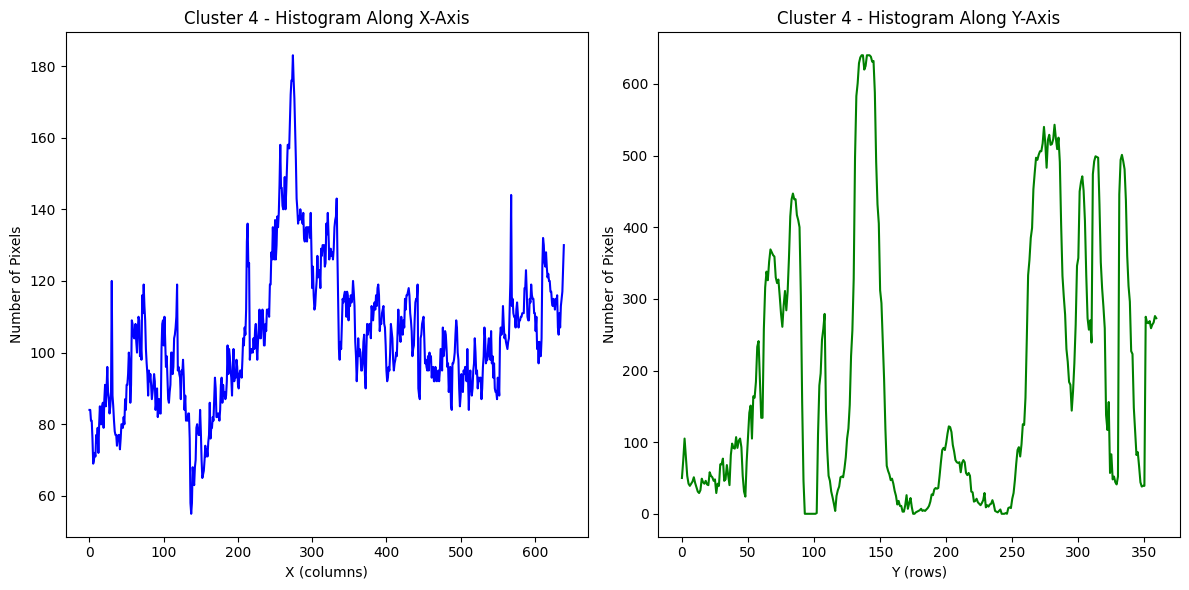

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def detect_pitch_with_histograms(image: np.ndarray, k: int = 5) -> None:
    """
    Detects clusters in the image using K-means and visualizes the clusters and histograms.

    Args:
        image (np.ndarray): Input image (H x W x 3) in RGB format.
        k (int): The number of clusters to detect (default is 3).
    """
    # Step 1: Convert RGB to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Step 2: Reshape the image to (num_pixels, 3) for clustering
    reshaped_image = hsv_image.reshape((-1, 3))

    # Step 3: Apply K-means for clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(reshaped_image)

    # Step 4: Get the labels of the clusters
    labels = kmeans.labels_

    # Step 5: Reshape the labels to the original image shape
    clustered_image = labels.reshape(image.shape[0], image.shape[1])

    # Step 6: Visualize the clusters on the image
    plt.figure(figsize=(10, 6))
    plt.imshow(clustered_image, cmap='jet')
    plt.title(f'Clusters Detected using K-means (k={k})')
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

    # Step 7: Compute histograms for each class
    for cluster_id in range(k):
        # Create a binary mask for the current cluster
        mask = (clustered_image == cluster_id).astype(np.uint8)

        # Sum pixels along each axis
        x_sum = mask.sum(axis=0)  # Sum along the y-axis (columns)
        y_sum = mask.sum(axis=1)  # Sum along the x-axis (rows)

        # Plot histograms for the current cluster
        plt.figure(figsize=(12, 6))

        # Plot the x-axis histogram
        plt.subplot(1, 2, 1)
        plt.plot(x_sum, color='blue')
        plt.title(f"Cluster {cluster_id} - Histogram Along X-Axis")
        plt.xlabel("X (columns)")
        plt.ylabel("Number of Pixels")

        # Plot the y-axis histogram
        plt.subplot(1, 2, 2)
        plt.plot(y_sum, color='green')
        plt.title(f"Cluster {cluster_id} - Histogram Along Y-Axis")
        plt.xlabel("Y (rows)")
        plt.ylabel("Number of Pixels")

        plt.tight_layout()
        plt.show()

# Example usage:
detect_pitch_with_histograms(equalized_image, k=5)


In [1]:
import torch 




In [2]:
torch.backends.cudnn.version()

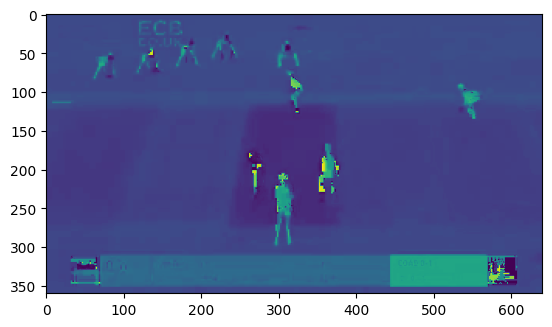

In [66]:
hsv_image = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_image[:,:,0])


In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def detect_pitch_using_dbscan(image: np.ndarray, eps: float = 30, min_samples: int = 100) -> None:
    """
    Detects clusters in the image using DBSCAN and visualizes the clusters.
    
    Args:
        image (np.ndarray): Input image (H x W x 3) in RGB format.
        eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood (default is 30).
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point (default is 100).
    """
    # Step 1: Convert RGB to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Step 2: Reshape the image to (num_pixels, 3) for clustering
    reshaped_image = hsv_image.reshape((-1, 3))
    
    # Step 3: Apply DBSCAN for clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(reshaped_image)
    
    # Step 4: Reshape the labels to the original image shape
    clustered_image = labels.reshape(image.shape[0], image.shape[1])
    
    # Step 5: Visualize the clusters on the image
    plt.figure(figsize=(10, 6))
    plt.imshow(clustered_image, cmap='jet')
    plt.title('Clusters Detected using DBSCAN')
    plt.axis('off')  # Hide axis for better visualization
    plt.show()


# Apply DBSCAN to detect clusters and visualize
detect_pitch_using_dbscan(frames[0])


: 

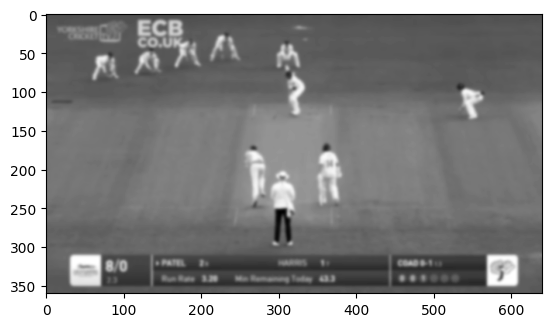

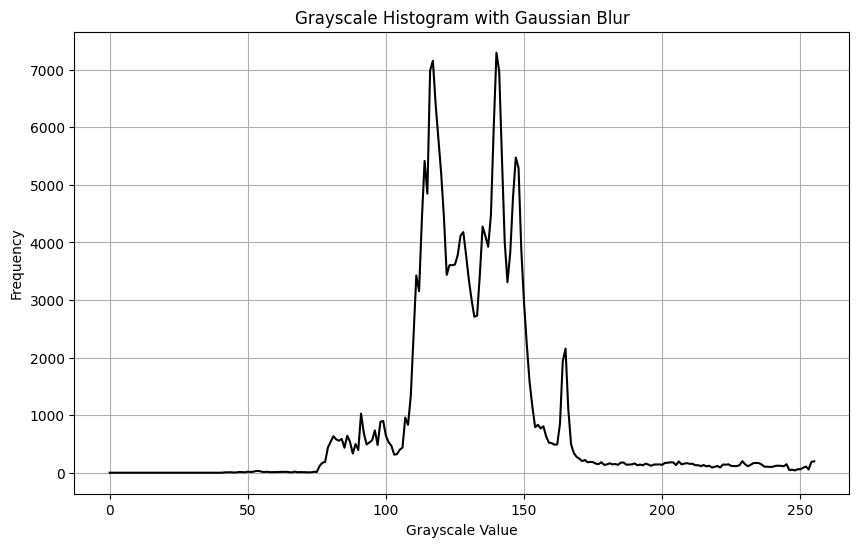

In [60]:
frame = frames[0]



compute_histogram_with_blur(frame, blur_kernel_size=(9,9))


In [7]:
a,b = detect_pitch(frames[0])

In [10]:
a

False

In [9]:
plt.imshow(b)

NameError: name 'plt' is not defined

In [56]:
diff = (frames[1:] - frames[0:8000-1] )

pitch_frame = frames[0]

diff = np.abs(frames - pitch_frame)

In [10]:
import numpy as np

In [ ]:
ref_frame = 
sim = np.einsum('f w h c, w h c -> f', frames, ref_frame)


In [10]:
import cv2
import numpy as np

# Assuming frames[0] is your image
image = frames[0]

# Step 1: Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Step 3: Detect edges using Canny Edge Detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Step 4: Find contours from edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Draw contours on the original image
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Green boundaries

# Display the result
cv2.imshow("Original Image", image)
cv2.imshow("Detected Edges", edges)
cv2.imshow("Boundaries Detected", image_with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()


: 

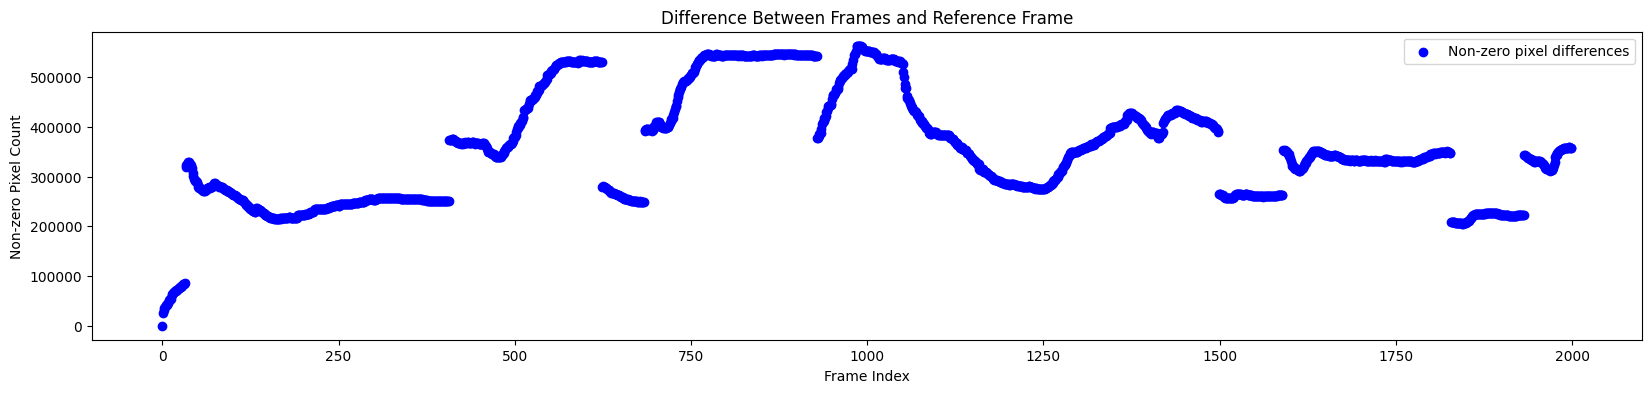

In [11]:
# Assuming frames is a NumPy array of shape (N, 360, 640, 3)
frames = np.array(frames)  # Ensure frames is a NumPy array
pitch_frame = frames[950]  # Reference frame (frame[0])

# Compute the absolute difference from pitch_frame for all frames
diff = np.abs(frames - pitch_frame)  # Shape remains (N, 360, 640, 3)

# Initialize list to store non-zero pixel counts
nonzero = []

# Compute non-zero counts for each frame
for i in range(len(diff)):
    # Thresholding (difference > 50)
    mask = (diff[i] > 50).astype(np.uint8)  # Binary mask: 1 if diff > 50
    num = np.count_nonzero(mask)  # Count non-zero pixels
    nonzero.append(num)

# Prepare for visualization
x = np.arange(0, len(frames))  # Frame indices
y = nonzero

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.scatter(x, y, c='blue', label='Non-zero pixel differences')
plt.xlabel('Frame Index')
plt.ylabel('Non-zero Pixel Count')
plt.title('Difference Between Frames and Reference Frame')
plt.legend()
plt.show()


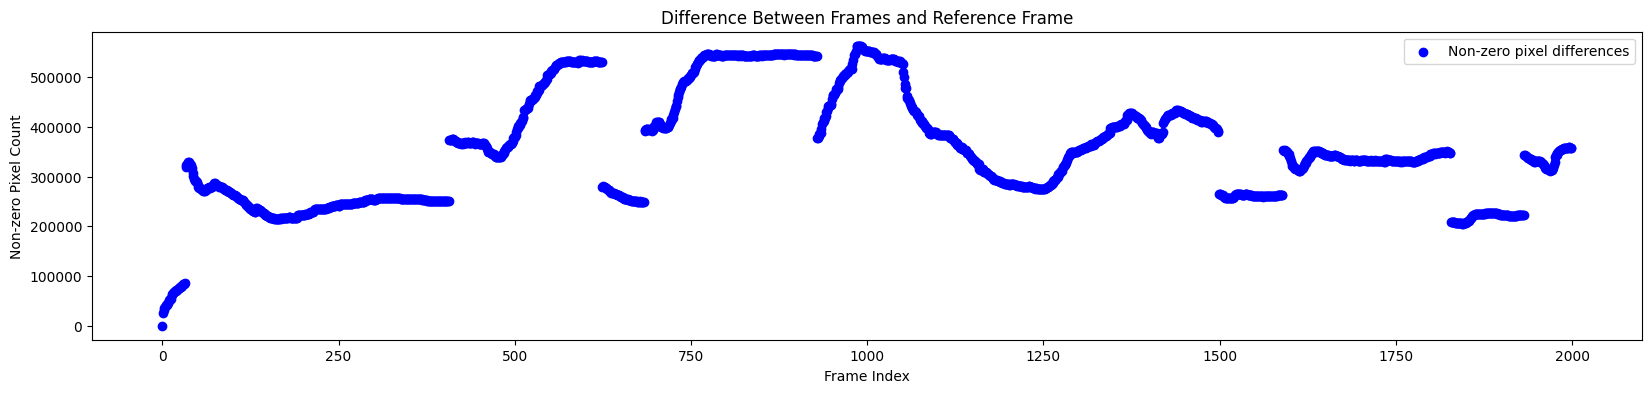

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming frames is a NumPy array of shape (N, 360, 640, 3)
frames = np.array(frames)  # Ensure frames is a NumPy array
pitch_frame = frames[0]  # Reference frame (frame[0])

# Compute absolute differences for all frames relative to pitch_frame
diff = np.abs(frames - pitch_frame)  # Shape: (N, 360, 640, 3)

# Apply thresholding (difference > 50) and create a binary mask
mask = (diff > 50).astype(np.uint8)  # Shape: (N, 360, 640, 3)

# Count non-zero pixels across the spatial dimensions (axis=(1, 2, 3))
nonzero = np.count_nonzero(mask, axis=(1, 2, 3))  # Shape: (N,)

# Prepare for visualization
x = np.arange(0, len(frames))  # Frame indices
y = nonzero

# Plot the results
plt.figure(figsize=(20, 4))
plt.scatter(x, y, c='blue', label='Non-zero pixel differences')
plt.xlabel('Frame Index')
plt.ylabel('Non-zero Pixel Count')
plt.title('Difference Between Frames and Reference Frame')
plt.legend()
plt.show()


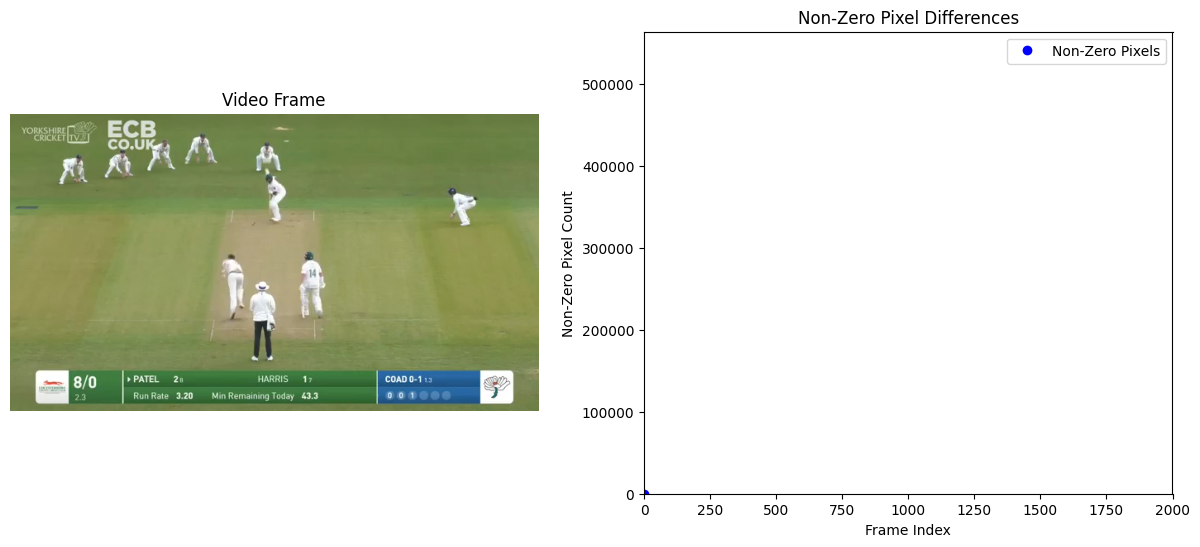

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming frames is a NumPy array of shape (N, 360, 640, 3)
frames = np.array(frames)  # Ensure frames is a NumPy array
pitch_frame = frames[0]  # Reference frame (frame[0])

# Compute absolute differences and count non-zero pixels
diff = np.abs(frames - pitch_frame)
mask = (diff > 50).astype(np.uint8)
nonzero = np.count_nonzero(mask, axis=(1, 2, 3))

# Prepare x-axis for plotting
x = np.arange(0, len(frames))

# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Video frame
ax1.set_title("Video Frame")
video_img = ax1.imshow(frames[0])  # Initialize with the first frame
ax1.axis('off')  # Remove axes for video

# Subplot 2: Non-zero pixel count plot
ax2.set_title("Non-Zero Pixel Differences")
ax2.set_xlim(0, len(frames))  # Set x-axis range
ax2.set_ylim(0, nonzero.max() + 100)  # Set y-axis range with padding
scatter_plot, = ax2.plot([], [], 'bo', label="Non-Zero Pixels")  # Initialize plot
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Non-Zero Pixel Count")
ax2.legend()

# Function to update the animation
def update(frame):
    # Update video frame
    video_img.set_data(frames[frame])  # Update the frame being displayed

    # Update scatter plot
    scatter_plot.set_data(x[:frame+1], nonzero[:frame+1])  # Update plot data
    return video_img, scatter_plot

# Create the animation
ani = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True)

# Display the animation
plt.show()


In [59]:
disim = diff[:,:,:,1].sum(axis=1).sum(axis=1)

In [32]:
pitch_frame.shape

(360, 640, 3)

In [36]:
out = np.einsum("f h w c, h w c -> f", frames, pitch_frame)

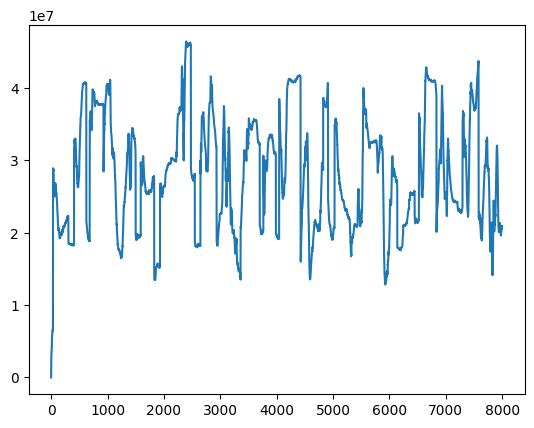

In [60]:
plt.plot(disim)

In [62]:
import numpy as np

def exponential_smoothing(data, alpha):
    """
    Perform exponential smoothing on a given dataset.

    Parameters:
        data (array-like): Input data to smooth.
        alpha (float): Smoothing factor (0 < alpha ≤ 1).

    Returns:
        np.ndarray: Smoothed data.
    """
    smoothed = np.zeros_like(data)  # Initialize an array for smoothed values
    smoothed[0] = data[0]  # First value is unchanged
    
    # Apply exponential smoothing
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t - 1]
    
    return smoothed




In [63]:
disim_sm = exponential_smoothing(disim,0.5)

In [ ]:
plt.imshow(frames[4])

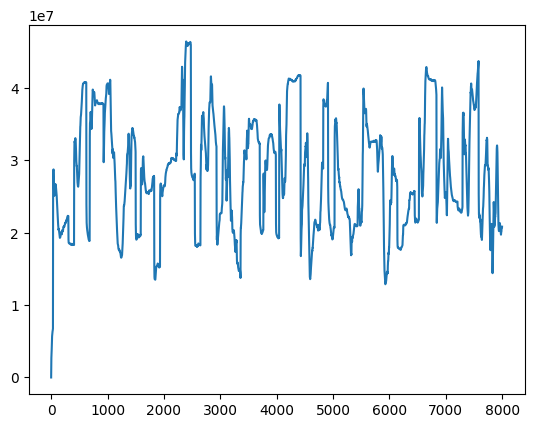

In [64]:
plt.plot(disim_sm)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [72]:
troughs, _ = find_peaks(disim_sm[1000:], prominence=1e2) 

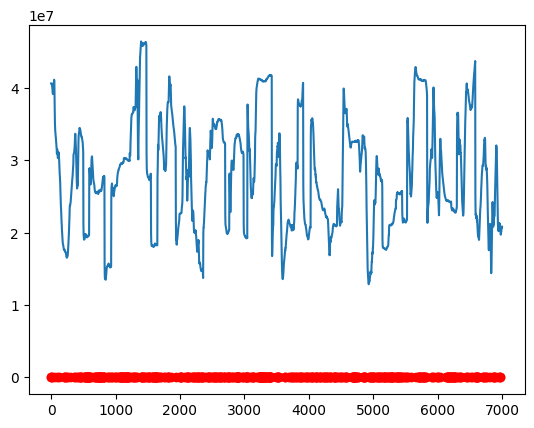

In [74]:
plt.plot(np.arange(7000), disim_sm[1000:])

plt.plot(np.arange(7000)[troughs] , troughs,'ro')

In [ ]:


# Example data: Load your time series here
# Assume `data` is your 1D time-series array
# timestamps = np.arange(len(data)) (if timestamps are implicit indices)

# Generate a sample plot like yours (replace this with actual data)
timestamps = np.linspace(0, 8000, 8000)
data = np.random.rand(8000) * 1e7  # Simulated data, replace with your own

# Find troughs (inverted peaks)
 # Adjust prominence threshold as needed

# Plot data with troughs marked
plt.figure(figsize=(8, 6))
plt.plot(timestamps, data, label="Data")
plt.plot(timestamps[troughs], data[troughs], "ro", label="Troughs")
plt.legend()
plt.title("Trough Detection")
plt.xlabel("Timestamps")
plt.ylabel("Value")
plt.show()

# Extract timestamps of troughs
trough_timestamps = timestamps[troughs]
print("Timestamps of Troughs:", trough_timestamps)


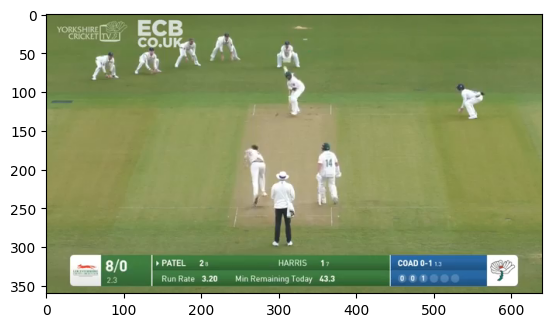

In [13]:
plt.imshow(frames[0])

In [ ]:



# a file like object works as well, for in-memory decoding
with open('examples/flipping_a_pancake.mkv', 'rb') as f:
  vr = VideoReader(f, ctx=cpu(0))
print('video frames:', len(vr))
# 1. the simplest way is to directly access frames
for i in range(len(vr)):
    # the video reader will handle seeking and skipping in the most efficient manner
    frame = vr[i]
    print(frame.shape)

# To get multiple frames at once, use get_batch
# this is the efficient way to obtain a long list of frames
frames = vr.get_batch([1, 3, 5, 7, 9])
print(frames.shape)
# (5, 240, 320, 3)
# duplicate frame indices will be accepted and handled internally to avoid duplicate decoding
frames2 = vr.get_batch([1, 2, 3, 2, 3, 4, 3, 4, 5]).asnumpy()
print(frames2.shape)
# (9, 240, 320, 3)

# 2. you can do cv2 style reading as well
# skip 100 frames
vr.skip_frames(100)
# seek to start
vr.seek(0)
batch = vr.next()
print('frame shape:', batch.shape)
print('numpy frames:', batch.asnumpy())
